- Importer ses images
- Importer le modèle
- Tester le modèle
- Extraire les couches et calculer les matrices de gram
- transformer une image en un vecteur (clean up)
- kmeans sur les données
- plot

In [1]:
import numpy as np
import os
from PIL import Image
import torch
from torchvision import models, transforms
import torch.nn as nn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Import des images

In [2]:
def load_image(path, size):

    img = Image.open(path)
    width, height = img.size

    square = min(width, height)

    left = (width - square) // 2
    top = (height - square) // 2
    right = left + square
    bottom = top + square

    # Découpe du carré central
    img_cropped = img.crop((left, top, right, bottom))

    # Redimensionnement
    img_resized = img_cropped.resize((size, size))

    return np.array(img_resized)


In [3]:
dir = 'C:\\Users\\Myria\\OneDrive - telecom-paristech.fr\\Documents\\2A\\IMA206\\Projet\\bd-peintres-v6'
size = 224

images_array = []
labels_array = []
peintres = ['dali - salvador-dali_1904', 'botticelli - sandro-botticelli_1444', 'cezanne - paul-cezanne_1839','kandinsky - vassily-kandinsky_1866', 'monet - claude-monet_1840']
for name in peintres :
    for filename in os.listdir(os.path.join(dir, name)):
        if filename.endswith(".jpg"):
            image_path = os.path.join(dir, name, filename)
            img_array = load_image(image_path, size)
            images_array.append(img_array)
            labels_array.append(name)

images_array = np.array(images_array)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(size)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

images_tensor = torch.stack([preprocess(img) for img in images_array])

In [5]:
images_tensor.shape

torch.Size([270, 3, 224, 224])

### Traitement de une image sur le modèle

In [6]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)  # [B, C, H*W]
    G = torch.bmm(features, features.transpose(1, 2))  # [B, C, C]
    return G / (c * h * w)  # Normalisation


In [7]:
class VGGFeatures(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.layers = layers
        self.selected = [int(k) for k in layers]

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.selected:
                features.append(x)
        return features


In [8]:
selected_layers = ['8', '15', '22']
model = VGGFeatures(selected_layers)
model.eval()

with torch.no_grad():
    feats = model(images_tensor)

c:\Users\Myria\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Myria\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
gram_vectors = []

for feat in feats:
    gram = gram_matrix(feat)  # [N, C, C]
    flattened = gram.view(gram.size(0), -1)  # [N, C*C]
    gram_vectors.append(flattened)

# Concaténer sur la dimension des features
all_grams = torch.cat(gram_vectors, dim=1).cpu().numpy()  # [N, total_features]


In [12]:
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(all_grams)

In [22]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=5)
labels = clustering.fit_predict(all_grams)


In [20]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=5, affinity='nearest_neighbors')
labels = clustering.fit_predict(all_grams)


In [ ]:
labels

In [23]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assure-toi que y_true est un vecteur de labels numériques
label_to_id = {name: i for i, name in enumerate(set(labels_array))}
y_true = [label_to_id[name] for name in labels_array]
cm = confusion_matrix(y_true, labels)

df_cm = pd.DataFrame(cm, index=label_to_id.keys(), columns=[f'Cluster {i}' for i in range(len(set(labels)))])
print(df_cm)

                                     Cluster 0  Cluster 1  Cluster 2  \
kandinsky - vassily-kandinsky_1866          19         10          0   
dali - salvador-dali_1904                    2         18          0   
botticelli - sandro-botticelli_1444          0         21          0   
monet - claude-monet_1840                    4          3         21   
cezanne - paul-cezanne_1839                  0         16         35   

                                     Cluster 3  Cluster 4  
kandinsky - vassily-kandinsky_1866           6          3  
dali - salvador-dali_1904                   12          7  
botticelli - sandro-botticelli_1444         15          0  
monet - claude-monet_1840                    5         35  
cezanne - paul-cezanne_1839                 29          9  


In [14]:
def show_cluster_images(images, labels, cluster_id, n=5):
    idxs = [i for i, lbl in enumerate(labels) if lbl == cluster_id][:n]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx])
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()


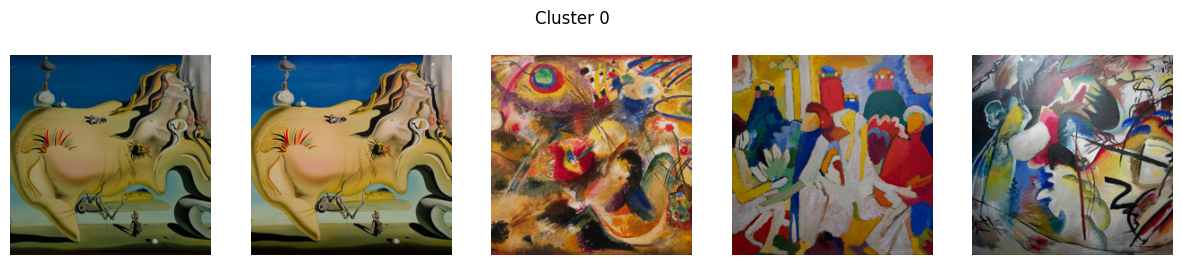

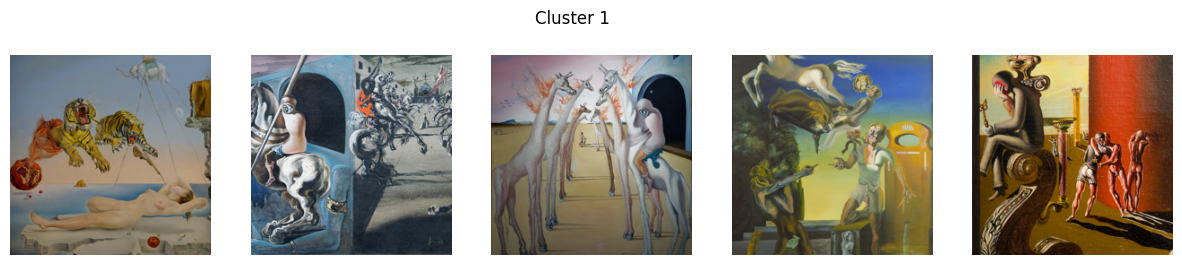

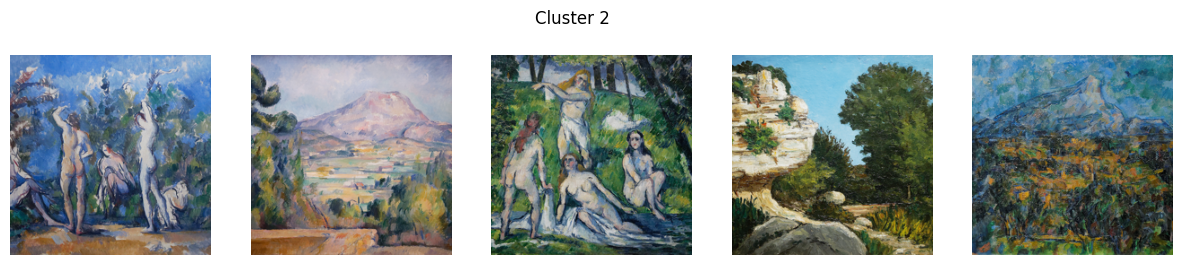

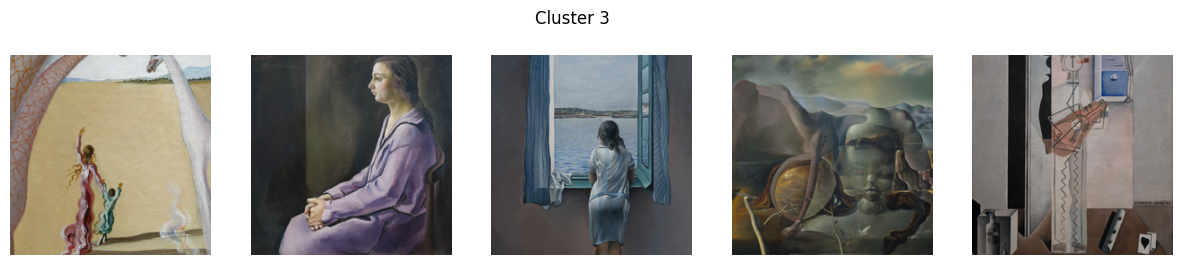

In [24]:
for cluster in range(4):
    show_cluster_images(images_array, labels, cluster)
